# Kütüphaneler

In [1]:
import csv
import numpy as np
import pandas as pd
import nltk 
from nltk.corpus import stopwords
import warnings
from snowballstemmer import TurkishStemmer

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn import decomposition, ensemble
import textblob
from textblob import TextBlob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# Veri Dosyasını Okuma

In [2]:
df= pd.read_csv("veriSeti.csv",  encoding = "utf16")
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

with pd.option_context("display.max_colwidth", None): display(df)


,Görüş,Durum
0,"ses kalitesi ve ergonomisi rezalet, sony olduğu için aldım ama 4'de 1 fiyatına çin replika ürün alsaydım çok çok daha iyiydi, kesinlikle tavsiye etmiyorum.",Olumsuz
1,hizli teslimat tesekkürler,Tarafsız
2,ses olayı süper....gece çalıştır sıkıntı yok.....kablo uzun işinizi çok rahat ettirir.....çekme olayı son derece güzel içiniz rahat olsun......diğerlerini saymıyorum bile.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye. etmem,Olumsuz
4,"Kulaklığın sesi kaliteli falan değil. Aleti öve öve bitiremeyen yorumlar şüpheli. Tizler yok gibi ve olan da boğuk çıkıyor. Bas, kaba saba, ben buradayım diyor ama kalite yok. İyi ses arayanlara tavsiye etmem. Hayatımda aldığım ilk Snopy marka üründü, onu da bazı yorumlara güvenerek aldım ve pişman oldum. Hepsiburada'nın sahte yorumlara karşı önlem alması gerekiyor artık.",Olumsuz
...,...,...
11424,biraz fazla ısınıyor ama sorumsuz çalışıyor,Tarafsız
11425,orijinal ürün fakat ambalaj bize ulaşana kadar param parça olmuş...,Tarafsız
11426,bu cihazı 1 yıldır kullanıyorum cihazı çok beğenerek aldım. fakat memnun kalmadm çok ses çıkarıyor sanki evde yayık cihazı çalışıyor . kıyafetleri de normal yıkıyor öyle etkileyici bı performansı yok .,Olumsuz
11427,Bir sene olmadı ayar düğmesine basıyorum ekran gidip geliyor,Tarafsız


# Metin Ön İşleme

In [3]:
#Noktalama işaretlerinin silinmesi
df['Görüş'] = df['Görüş'].str.replace('[^\w\s]','')

#Sayıların silinmesi
df['Görüş'] = df['Görüş'].str.replace('\d','')

#Büyük-Küçük harf dönüştürme
df["Görüş"] = df["Görüş"].apply(lambda x: " ".join(i.lower() for i in str(x).split()))

#Stopwordslerin silinmesi
sw = stopwords.words("turkish")
df['Görüş'] = df['Görüş'].apply(lambda x: " ".join(x for x in x.split() if x not in sw ))

#Stemmening
turkStem=TurkishStemmer()
df["Görüş"] = df["Görüş"].apply(lambda x: " ".join(turkStem.stemWord(i) for i in str(x).split()))

df.loc[df["Durum"] == "Tarafsız", "Durum"] = np.nan
df.dropna(inplace = True)

with pd.option_context("display.max_colwidth", None): display(df)
warnings.filterwarnings("ignore")

#df.head(10)
#df.tail(10)

C:\Users\eralt\AppData\Local\Temp\ipykernel_2612\3674110525.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Görüş'] = df['Görüş'].str.replace('[^\w\s]','')
C:\Users\eralt\AppData\Local\Temp\ipykernel_2612\3674110525.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Görüş'] = df['Görüş'].str.replace('\d','')


,Görüş,Durum
0,ses kalites ergonomis rezalet sony olduk al fiyat çin replika ür alsa i kesinlik tavsi etmiyor,Olumsuz
2,ses ola süpergeç çalış sık yokkablo uz iş rahat ettirirçekme ola son dereç güzel iç rahat olsundiğer saymıyor bil,Olumlu
3,gel bigi kulla heme bozol hiçtavsi etme,Olumsuz
4,kulaklık ses kalitel fala değil alet öv öv bitiremeye yorum şüphel tiz yok ola boğuk çıkıyor bas kap sap ben bura diyor kali yok i̇yi ses arayan tavsi etme hayat aldık ilk snopy marka ür on yorum güvenerek al pişma ol hepsiburada sahte yorum karşı önle almas gerekiyor ar,Olumsuz
6,kullanisli ba,Olumlu
...,...,...
11421,yaklaşık bir ay ö anne al hedi olarak beğe memn kullanışlıs filtrel olmas hava toz emmes süper ev gereklifiyat gör uygu bir ürünhepsi burada teşekkürlersipariş verdik gün kargo verilmiştisüper hızlı ben p der,Olumlu
11422,beğe hızlı pişiriyor,Olumlu
11423,ür an kadar beğe standart uygulama kullanıyor zate telefo fazla yeterli ekra büyük hızlı çalışıyor şarj süresi kullanma süre gör gün yeterli oluyor beğe,Olumlu
11426,cihaz yıl kullanıyor cihaz beğenerek al fakat memn kalmadm ses çıkarıyor ev yayık cihaz çalışıyor kıyafet normal yıkıyor ö etkileyiç bı performansı yok,Olumsuz


In [4]:
df = df[(df.Durum == "Olumlu") | (df.Durum == "Olumsuz") | (df.Durum == "Tarafsız")]
df.groupby("Durum").count()

,Görüş
Durum,
Olumlu,4242
Olumsuz,4228


# Train - Test Uygulaması

In [5]:
train_df = pd.DataFrame()
train_df["text"] = df["Görüş"]
train_df["label"] = df["Durum"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(train_df["text"], train_df["label"], test_size = 0.30, random_state = 42)
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

#Count Vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

#TF-IDF
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vectorizer.fit(train_x)
x_train_tf_idf = tf_idf_vectorizer.transform(train_x)
x_test_tf_idf = tf_idf_vectorizer.transform(test_x)


# Denetimli Makine Öğrenmesi

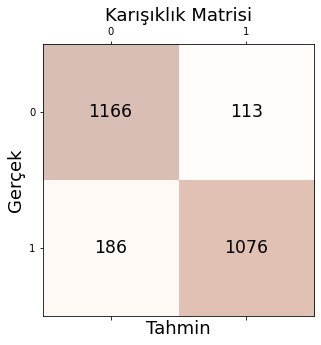

Naive Bayes Count Vectors Doğruluk Oranı: 0.874847923421337
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1279
           1       0.90      0.85      0.88      1262

    accuracy                           0.88      2541
   macro avg       0.88      0.88      0.88      2541
weighted avg       0.88      0.88      0.88      2541



In [6]:
#Naive Bayes
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(nb_model, x_test_count, test_y, cv = 10).mean()

y_pred = nb_model.predict(x_test_count)
conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Tahmin', fontsize=18)
plt.ylabel('Gerçek', fontsize=18)
plt.title('Karışıklık Matrisi', fontsize=18)
plt.show()

print("Naive Bayes Count Vectors Doğruluk Oranı:", accuracy)
print(classification_report(test_y, y_pred))

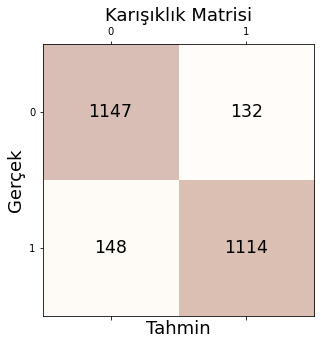

Naive Bayes TF-IDF Doğruluk Oranı: 0.8815392928825073
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1279
           1       0.89      0.88      0.89      1262

    accuracy                           0.89      2541
   macro avg       0.89      0.89      0.89      2541
weighted avg       0.89      0.89      0.89      2541



In [7]:
#Naive Bayes
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_tf_idf,train_y)
accuracy = model_selection.cross_val_score(nb_model, x_test_tf_idf, test_y, cv = 10).mean()

y_pred = nb_model.predict(x_test_tf_idf)
conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Tahmin', fontsize=18)
plt.ylabel('Gerçek', fontsize=18)
plt.title('Karışıklık Matrisi', fontsize=18)
plt.show()

print("Naive Bayes TF-IDF Doğruluk Oranı:", accuracy)
print(classification_report(test_y, y_pred))

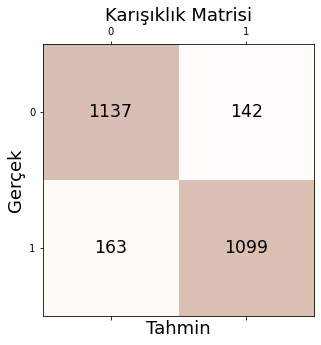

Lojistik Regresyon Count Vectors Doğruluk Oranı: 0.8658005249343832
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1279
           1       0.89      0.87      0.88      1262

    accuracy                           0.88      2541
   macro avg       0.88      0.88      0.88      2541
weighted avg       0.88      0.88      0.88      2541



In [8]:
#Lojistik regresyon
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(loj_model, x_test_count, test_y, cv = 10).mean()

y_pred = loj_model.predict(x_test_count)
conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Tahmin', fontsize=18)
plt.ylabel('Gerçek', fontsize=18)
plt.title('Karışıklık Matrisi', fontsize=18)
plt.show()

print("Lojistik Regresyon Count Vectors Doğruluk Oranı:", accuracy)
print(classification_report(test_y, y_pred))

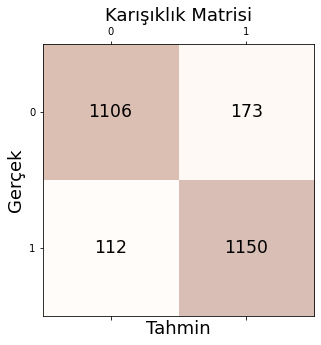

Lojistik Regresyon TF-IDF Doğruluk Oranı: 0.8732823838196696
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1279
           1       0.87      0.91      0.89      1262

    accuracy                           0.89      2541
   macro avg       0.89      0.89      0.89      2541
weighted avg       0.89      0.89      0.89      2541



In [9]:
#Lojistik regresyon
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_tf_idf,train_y)
accuracy = model_selection.cross_val_score(loj_model, x_test_tf_idf, test_y, cv = 10).mean()

y_pred = loj_model.predict(x_test_tf_idf)
conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Tahmin', fontsize=18)
plt.ylabel('Gerçek', fontsize=18)
plt.title('Karışıklık Matrisi', fontsize=18)
plt.show()

print("Lojistik Regresyon TF-IDF Doğruluk Oranı:", accuracy)
print(classification_report(test_y, y_pred))

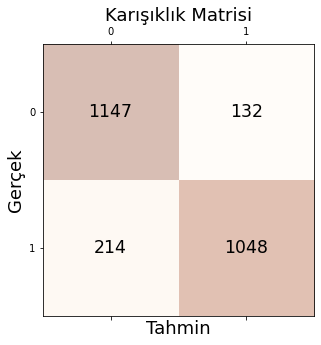

SVM(Linear) Count Vectors Doğruluk Oranı: 0.8571452833101745
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1279
           1       0.89      0.83      0.86      1262

    accuracy                           0.86      2541
   macro avg       0.87      0.86      0.86      2541
weighted avg       0.87      0.86      0.86      2541



In [10]:
#Destek Vektör Sınıflandırıcısı
svc_model = SVC(kernel='linear')
svc_model.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(svc_model, x_test_count, test_y, cv = 10).mean()

y_pred = svc_model.predict(x_test_count)
conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Tahmin', fontsize=18)
plt.ylabel('Gerçek', fontsize=18)
plt.title('Karışıklık Matrisi', fontsize=18)
plt.show()

print("SVM(Linear) Count Vectors Doğruluk Oranı:", accuracy)
print(classification_report(test_y, y_pred))

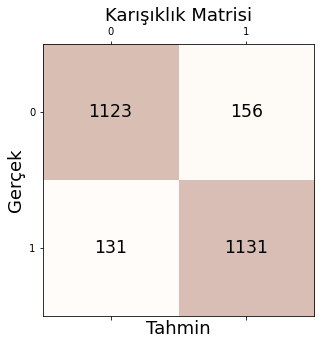

SVM(Linear) TF-IDF Doğruluk Oranı: 0.8839030415315733
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1279
           1       0.88      0.90      0.89      1262

    accuracy                           0.89      2541
   macro avg       0.89      0.89      0.89      2541
weighted avg       0.89      0.89      0.89      2541



In [11]:
#Destek Vektör Sınıflandırıcısı
svc_model = SVC(kernel='linear')
svc_model.fit(x_train_tf_idf,train_y)
accuracy = model_selection.cross_val_score(svc_model, x_test_tf_idf, test_y, cv = 10).mean()

y_pred = svc_model.predict(x_test_tf_idf)
conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Tahmin', fontsize=18)
plt.ylabel('Gerçek', fontsize=18)
plt.title('Karışıklık Matrisi', fontsize=18)
plt.show()

print("SVM(Linear) TF-IDF Doğruluk Oranı:", accuracy)
print(classification_report(test_y, y_pred))

In [ ]:
#Destek Vektör Sınıflandırıcısı
svc_model = SVC(kernel='rbf')
svc_model.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(svc_model, x_test_count, test_y, cv = 10).mean()

y_pred = svc_model.predict(x_test_count)
conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Tahmin', fontsize=18)
plt.ylabel('Gerçek', fontsize=18)
plt.title('Karışıklık Matrisi', fontsize=18)
plt.show()

print("SVM(RBF) Count Vectors Doğruluk Oranı:", accuracy)
print(classification_report(test_y, y_pred))

In [ ]:
#Destek Vektör Sınıflandırıcısı
svc_model = SVC(kernel='rbf')
svc_model.fit(x_train_tf_idf,train_y)
accuracy = model_selection.cross_val_score(svc_model, x_test_tf_idf, test_y, cv = 10 ).mean()

y_pred = svc_model.predict(x_test_tf_idf)
conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Tahmin', fontsize=18)
plt.ylabel('Gerçek', fontsize=18)
plt.title('Karışıklık Matrisi', fontsize=18)
plt.show()

print("SVM(RBF) TF-IDF Doğruluk Oranı:", accuracy)
print(classification_report(test_y, y_pred))